# Compare atmospheric simulation in libradtran and in lsstsim

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import colors, ticker, cm   
import matplotlib.cm as cmx
%matplotlib inline
import sys
import os
import pandas as pd
import glob
from matplotlib.backends.backend_pdf import PdfPages 

In [3]:
from scipy.interpolate import interp1d

In [4]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 10),   #defines the default image size
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [5]:
from Telescope import *
from Throughputs import *

In [6]:
PATH_LIBRADTRAN='./libradtran'

In [7]:
sys.path.append(PATH_LIBRADTRAN)

In [8]:
from libsimulateTranspLSSTScattAbsAer3 import *

In [9]:
#------------------------------------------------------------------------
# Definition of data format for the atmospheric grid
#-----------------------------------------------------------------------------
WLMIN=300.  # Minimum wavelength : PySynPhot works with Angstrom
WLMAX=1100. # Minimum wavelength : PySynPhot works with Angstrom
WL=np.arange(WLMIN,WLMAX,1) # Array of wavelength in Angstrom
NBWL=len(WL)


In [10]:
airmasses=np.linspace(1.,2,10.)
pressure = 782.5
pwv=4.0
aer=0
ozone=300.
wl0=500.

/sps/lsst/software/lsst_sims/sims_2_7_0/python/miniconda3-4.3.21/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  """Entry point for launching an IPython kernel.


In [11]:
NBOBS=len(airmasses)

In [12]:
all_transmission_rt=np.zeros((NBWL,NBOBS))

In [13]:
all_transmission_lsstsim=np.zeros((NBWL,NBOBS))

## Simulation with libradtran

In [14]:
idx=0
for am in airmasses:
    path,thefile=ProcessSimulationaer(am,pwv,ozone,wl0,aer)
    #path,thefile=ProcessSimulation(am,pwv,ozone)
    data = np.loadtxt(os.path.join(path,thefile))
    wl = data[:,0]
    atm = data[:,1]  
    func=interp1d(wl,atm,kind='linear') 
    transm=func(WL)
    all_transmission_rt[:,idx]=transm
    idx+=1

--------------------------------------------
 1) airmass =  1.0
 2) pwv =  4.0
 3) oz =  300.0
 4) wl0 =  500.0
 5) tau0 =  0
--------------------------------------------
Running uvspec with input file:  simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z10_wv40_oz30_aer0.INP
Output to file                :  simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z10_wv40_oz30_aer0.OUT
uvspec cmd:  /pbs/throng/lsst/users/dagoret/External/libRadtran/libRadtran-2.0.1/bin/uvspec  < simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z10_wv40_oz30_aer0.INP > simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z10_wv40_oz30_aer0.OUT
--------------------------------------------
 1) airmass =  1.11111111111
 2) pwv =  4.0
 3) oz =  300.0
 4) wl0 =  500.0
 5) tau0 =  0
--------------------------------------------
Running uvspec with input file:  simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z11_wv40_oz30_aer0.INP
Output to file                :  simulations/RT/2.

In [15]:
jet =plt.get_cmap('jet')    
cNorm  = colors.Normalize(vmin=0, vmax=NBOBS)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)

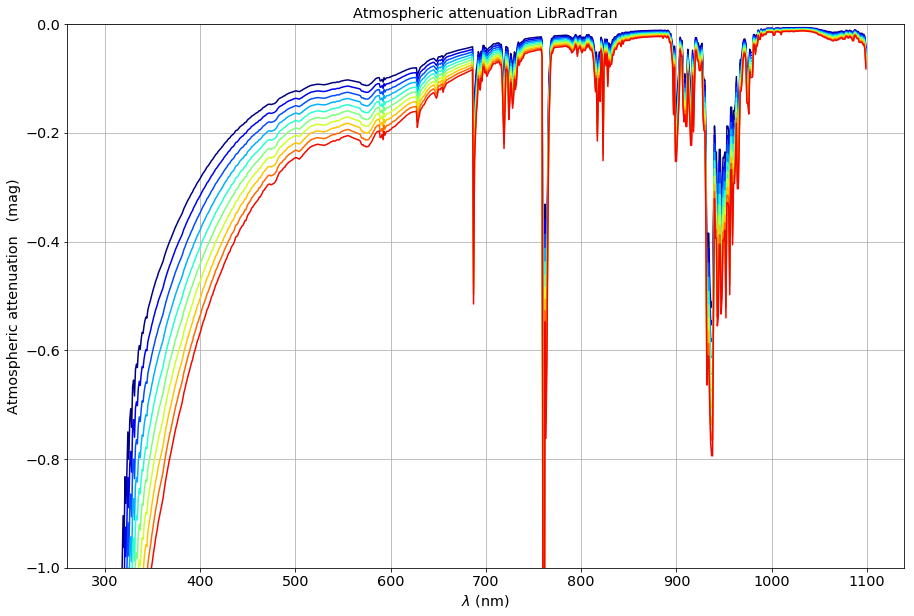

In [16]:
idx=0
for am in airmasses:
    colorVal = scalarMap.to_rgba(idx,alpha=1)
    plt.plot(WL,2.5*np.log10(all_transmission_rt[:,idx]),color=colorVal)
    idx+=1
plt.xlabel("$\lambda$ (nm)")
plt.ylabel("Atmospheric attenuation   (mag)")
plt.title("Atmospheric attenuation LibRadTran")
plt.ylim(-1.,0.)
plt.grid()

## Atmosphere from LSST_SIM

In [17]:
tel=Telescope(airmass=1,aerosol=False)

In [18]:
#dir(tel.atmos)

In [19]:
#tel.atmos.wavelen

In [20]:
#tel.atmos.sb

In [21]:
idx=0
for am in airmasses:
    
    tel=Telescope(airmass=am,aerosol=False)
    wl = tel.atmos.wavelen
    atm = tel.atmos.sb
    func=interp1d(wl,atm,kind='linear') 
    transm=func(WL)
    all_transmission_lsstsim[:,idx]=transm
    idx+=1

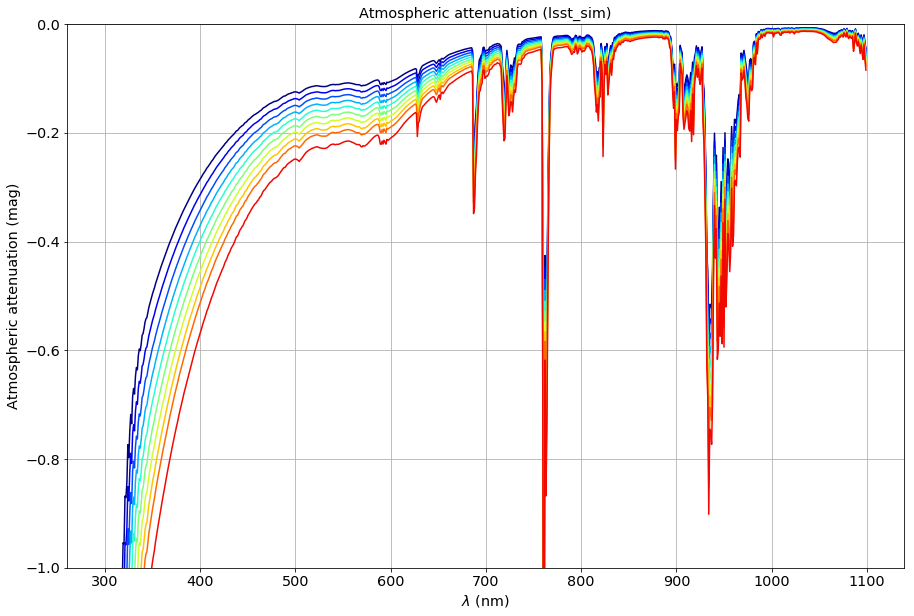

In [22]:
idx=0
for am in airmasses:
    colorVal = scalarMap.to_rgba(idx,alpha=1)
    plt.plot(WL,2.5*np.log10(all_transmission_lsstsim[:,idx]),color=colorVal)
    idx+=1
plt.xlabel("$\lambda$ (nm)")
plt.ylabel("Atmospheric attenuation (mag)")
plt.title("Atmospheric attenuation (lsst_sim)")
plt.ylim(-1.,0.)
plt.grid()

## Ratio

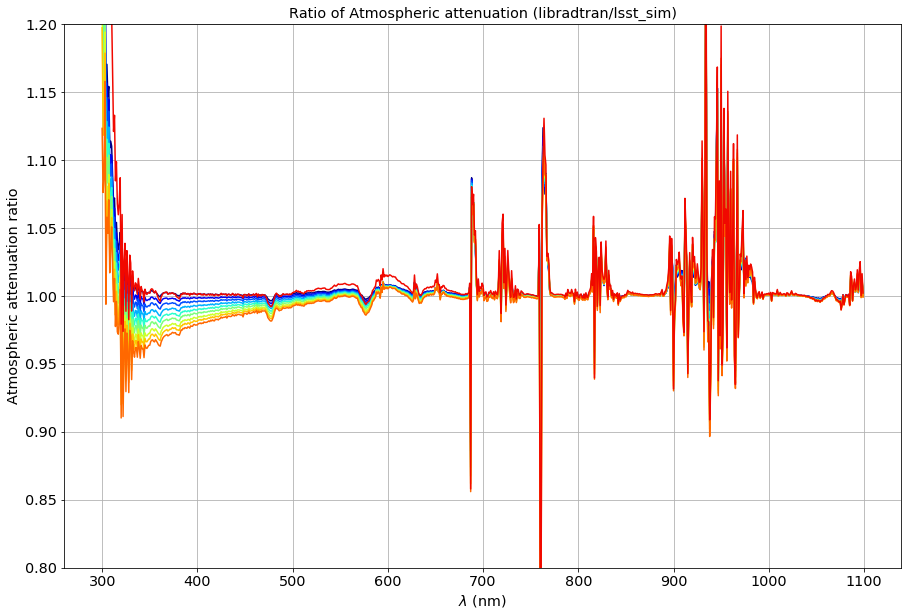

In [23]:
idx=0
for am in airmasses:
    colorVal = scalarMap.to_rgba(idx,alpha=1)
    plt.plot(WL,all_transmission_rt[:,idx]/all_transmission_lsstsim[:,idx],color=colorVal)
    idx+=1
plt.xlabel("$\lambda$ (nm)")
plt.ylabel("Atmospheric attenuation ratio")
plt.title("Ratio of Atmospheric attenuation (libradtran/lsst_sim)")
plt.ylim(0.8,1.2)
plt.grid()